# CX 4230, Spring 2016: [40] Generating power law distributions

When studying dynamical systems on networks, we saw cases in which the structure of the graph played a role through the structure of the adjacency matrix as well as the _degree_ of every node. Thus, we might want to know how certain structures and _degree distributions_ arise.

This notebook considers one such generative process, known as the _preferential attachment_ model. The model has been rediscovered several times; the variant considered here is due to [Barabási and Albert (1999)](http://science.sciencemag.org/content/286/5439/509).

## Setup: A real-world network

Let's start by downloading an engineered network system, namely, the graph corresponding to the topology of internet routers: https://snap.stanford.edu/data/as-skitter.html

In [1]:
import random
import numpy as np
import scipy.sparse as sps

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import os
if not os.path.exists ('nets/'):
    os.makedirs ('nets/')
    
import urllib.request
if not os.path.exists ('nets/as-skitter.zip'):
    urllib.request.urlretrieve ('https://cx4230.gatech.edu/sp16/nets/as-skitter.zip',
                                'nets/as-skitter.zip')

In [4]:
import zipfile
from collections import defaultdict

def read_net (name, fn_zip=None, fn_net=None, verbose=True, force_undir=True):
    if not fn_zip:
        fn_zip = 'nets/%s.zip' % name
    if not fn_net:
        fn_net = '%s.txt' % name
        
    # Open zip archive
    f_archive = zipfile.ZipFile (fn_zip, 'r') ; assert f_archive
    
    # Extract network file from archive as file-like object
    f_net = f_archive.open (fn_net, 'r') ; assert f_net
    
    # Read header
    line_num = 0
    while f_net:
        line_bytes = f_net.readline ()
        if not line_bytes:
            break
        line_num += 1
        
        line_text = line_bytes.decode ('utf-8').strip ()
        if line_text[0] == '#': # header line
            if verbose:
                print ('%d: %s' % (line_num, line_text))
        else:
            break
            
    # Network data follows as a list of vertex pairs.
    I, J = [], []
            
    # EOF or first read line
    while line_text:
        fields = line_text.split (sep='\t')
        if len (fields) != 2:
            print ("*** Error reading line %d: '%s'" % (line_num, line_text))
            assert len (fields) == 2
            
        source, target = int (fields[0]), int (fields[1])
        I.append (source) ; J.append (target)
        if force_undir:
            J.append (source) ; I.append (target)
        
        if not f_net: # EOF
            break
            
        line_bytes = f_net.readline ()
        if not line_bytes: # EOF
            break
            
        line_num += 1
        line_text = line_bytes.decode ('utf-8').strip ()
            
    # File cleanup
    del f_net
    del f_archive
        
    return I, J

GRAPHNAME = 'as-skitter'
I, J = read_net (GRAPHNAME)

1: # Undirected graph: as-skitter.txt
2: # Autonomous Systems (From traceroutes run daility in 2005 by skitter - http://www.caida.org/tools/measurement/skitter)
3: # Note: There were 22622 nodes with degree 0
4: # Nodes: 1696415 Edges: 11095298
5: # FromNodeId	ToNodeId


In [5]:
A_net = sps.coo_matrix (([1.0]*len (I), (I, J))).tocsr ()

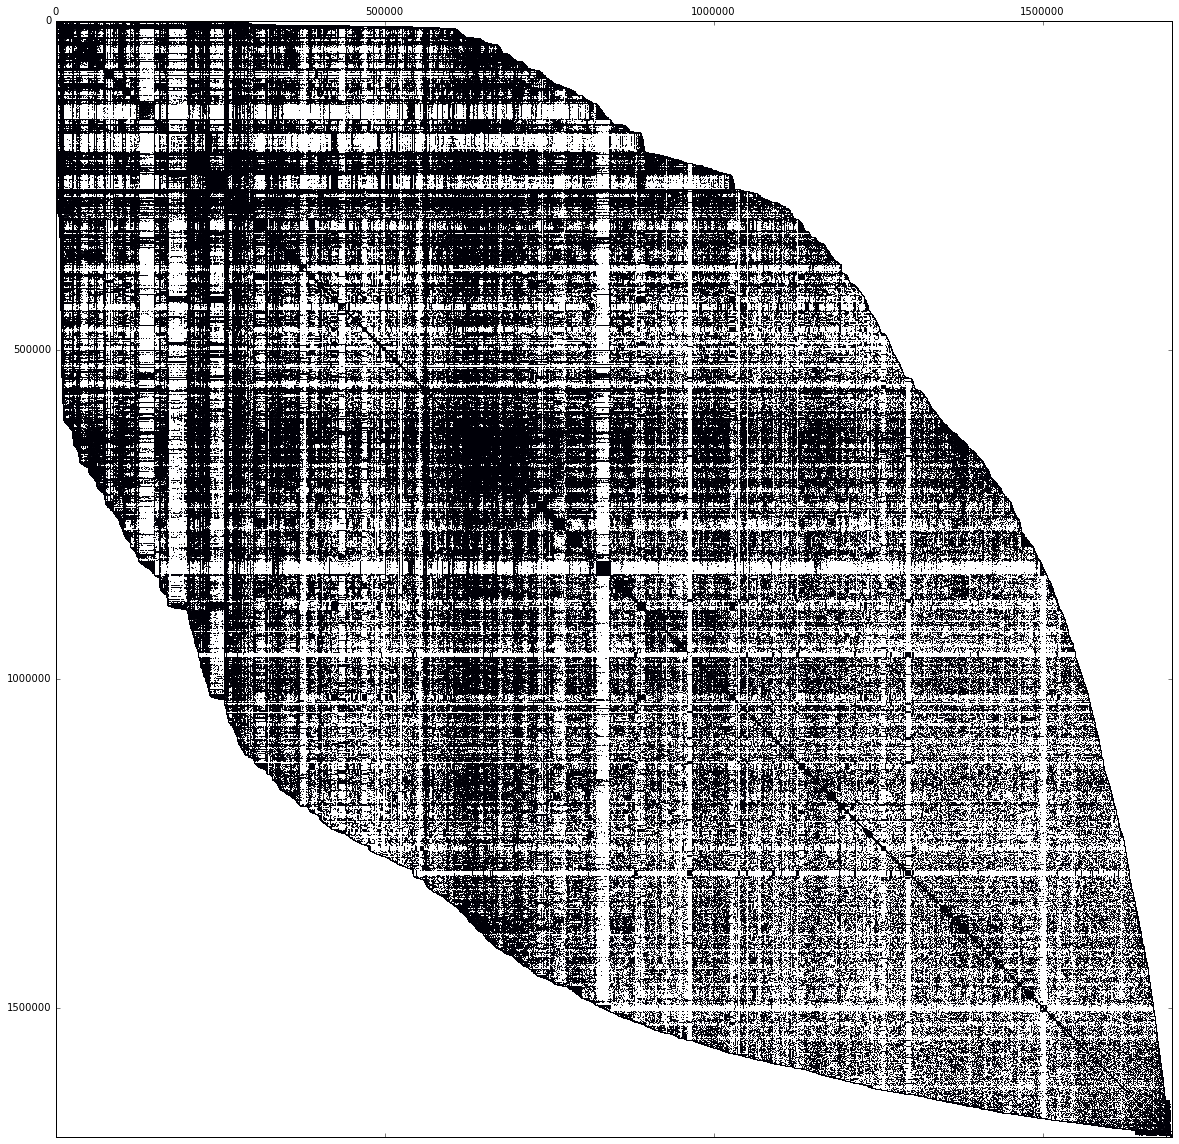

In [6]:
def spy (A, figsize=(20, 20), markersize=0.5):
    fig = plt.figure (figsize=figsize)
    plt.spy (A, markersize=markersize)
    plt.show ()
    
# Render graph as sparse matrix
spy (A_net)

In [7]:
from collections import defaultdict
from itertools import accumulate

def degrees (A):
    return np.squeeze (np.asarray (A.sum (axis=0)))

def degree_dist (A):
    sparse_hist = defaultdict (int)
    for d in degrees (A):
        sparse_hist[d] += 1
    degs = sorted (sparse_hist.keys ())
    counts = [sparse_hist[d] for d in degs]
    return degs, counts

def plot_degree_dist (A, cumulative=False, fig=None, figsize=(7, 7)):
    degs, counts = degree_dist (A)
    if cumulative:
        total = sum (counts)
        orig_counts = counts
        for i, c in enumerate (accumulate (orig_counts)):
            counts[i] = total - c
    if not fig:
        fig = plt.figure (figsize=figsize)
        plt.axes().set_aspect('equal')
    plt.loglog (degs, counts, '*')
    plt.grid (True)
    plt.xlabel ("degree (log-scale)")
    plt.title ("count (log-scale)")

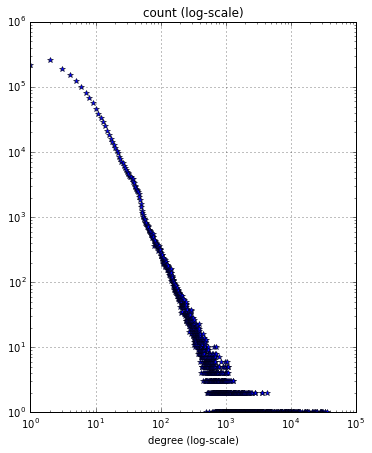

In [8]:
plot_degree_dist (A_net)

**Exercise.** What is the exponent of a power law distribution that might fit this data? That is, if $d$ is the degree, then for what $\alpha$ does the data best fit a curve of the form $\dfrac{1}{d^{\alpha}}$?

> Answer:  2.3

## Preferential attachment model

The preferential attachment model uses the following process to generate an _undirected_ network of $n$ vertices.

Initially, the network has $n_0 < n$ vertices, numbered $\{0, 1, ..., n_0-1\}$ with no edges. Each of the remaining vertices is generated one at a time, starting at vertex $n_0$, according to the following process:

1. Let $i$ denote the new vertex; at the start, $i=n_0$.
2. Let the probability of choosing any vertex $j < i$ be proportional to $d_j$, where $d_j$ is the degree of vertex $j$.
> Initially, since the first $n_0$ vertices have no edges, let the initial probabilities be uniform, i.e., the probability of choosing $j$ is just $1 / n_0$.
3. Using this degree-weighted probability distribution, connect $i$ to exactly $c$ of the vertices less than $i$, chosen randomly without replacement.

**Exercise.** According to this process, how many edges will be produced?

> Answer: (n-n_0)*c

In [9]:
N_INITIAL = 3 # Number of vertices, initially
N_FINAL = 10000 # Number of vertices, finally
C = 3 # Number of initial connections per new vertex

assert N_FINAL > N_INITIAL
assert C <= N_INITIAL

**Exercise.** Simulate the preferential attachment process and see if the degree distribution matches. In particular, write some code to produce a sparse matrix `A` (in CSR format) that holds the adjacency matrix of a graph generated by a preferential attachment process. That is, $a_{ij} = 1$ if there is a _directed_ edge $(i, j)$, or 0 otherwise; and since the final graph should be undirected, $a_{ij} = 1$ means $a_{ji} = 1$, too.

> Hint 1: You may find [`numpy.random.choice()`](http://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.random.choice.html) handy.
>
> Hint 2: Create a CSR matrix from row indices `row_ind[:]`, column indices `col_ind[:]`, and values `val[:]` using:
>
>     sps.coo_matrix ((vals, (row_ind, col_ind))).tocsr ()

In [10]:
# Indices of all N_FINAL vertices
vertices = np.arange (N_FINAL)

# Create a network with M0 vertices
degree = np.zeros (N_FINAL) # degree[i] = degree of vertex i
prob = np.zeros (N_FINAL) # prob[i] = probability of linking to vertex i

# Initially, let each of the initial vertices be equally likely
prob[:N_INITIAL] = 1.0 / N_INITIAL

# Maintain a list of directed edges, {(sources[k], targets[k])},
# initially empty
M_FINAL = (N_FINAL - N_INITIAL) * C * 2 # max number of edges
sources = -np.ones (M_FINAL)
targets = -np.ones (M_FINAL)

m = 0 # number of edges so far
for t in range (N_INITIAL, N_FINAL):
    # @YOUSE: Fill in this code.
    samples = np.random.choice(vertices[:t],p=prob[:t], replace=False, size=C)

    sources[m: m+C] = t
    targets[m: m+C] = samples
    sources[m+C: m+2*C] = samples
    targets[m+C: m+2*C] = t
    m += 2*C
    degree[t] += C
    degree[samples] += 1
    prob = degree / sum(degree)
        
    # Suggested steps:
    # 1. Generate neighbors -- see np.random.choice()
    # 2. Record edges and update their number (m)
    # 3. Update probabilities
val = np.ones (M_FINAL)
A = sps.coo_matrix ((val, (sources, targets))).tocsr ()

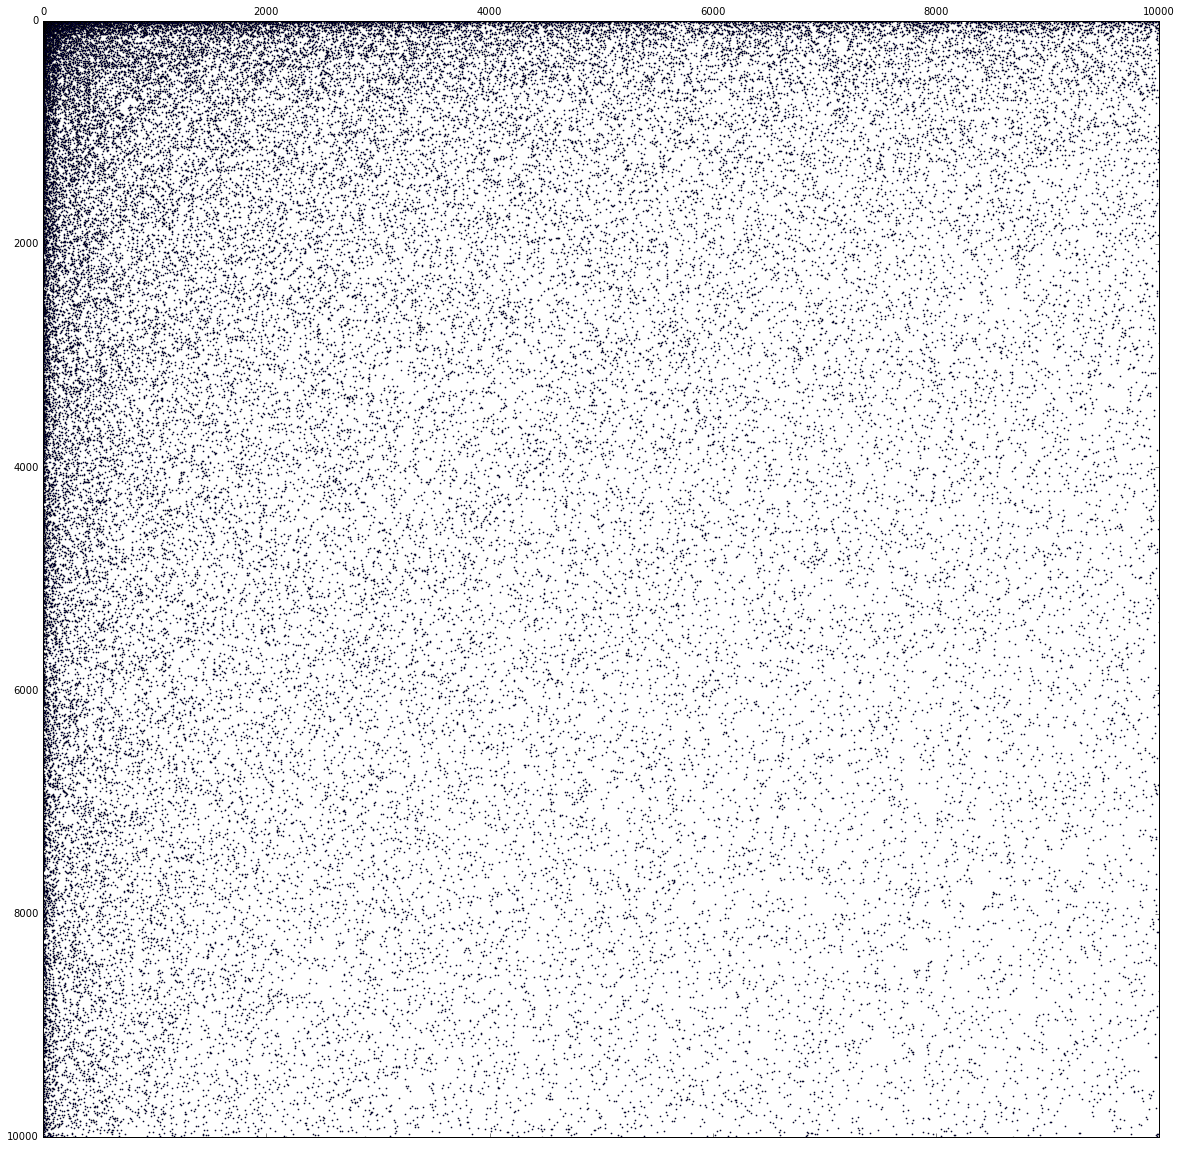

In [11]:
spy (A, markersize=1)

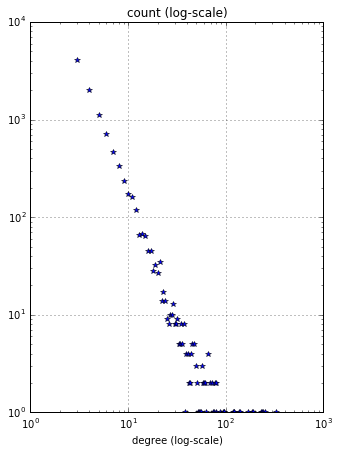

In [12]:
plot_degree_dist (A)

**Exercise.** Run the above for $n=10,000$. What is the exponent of the power law distribution that best fits this data?

> Answer: 1.8